In [1]:
%matplotlib inline

from collections import Counter, defaultdict, namedtuple, deque
import itertools
import random
import copy

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
import networkx as nx
from graphviz import Digraph

# Solving Problems by Searching

* Atomic vs non-atomic repressentations
* Uninformed vs Informed

## Problem-Solving Agents

Steps:
* Goal formulation
* Problem formulation

## Example Problems

In [2]:
def space(p):
    return list(generate_space(p))

def generate_space(p):
    seen = {p.initial_state()}
    frontier = deque([p.initial_state()])
    yield p.initial_state()
    while frontier:
        s = frontier.popleft()
        for a in p.actions(s):
            new = p.result(s, a)
            if new not in seen:
                seen.add(new)
                frontier.append(new)
                yield new

def graph(p, limit=None):
    states = space(p) if limit is None else itertools.islice(generate_space(p), limit)
    return {
        state: {p.result(state, a): p.step_cost(state, a, p.result(state, a)) for a in p.actions(state)}
        for state in states
    }

### Machinarium Docks Hoist Puzzle

#### Prblem

![Docks Hoist Puzzle](./images/Mini-game_7.jpg)

#### Solution

![Docks Hoist Puzzle Solution](./images/Mini-game_7_walkthrough_book_hint.jpg)

#### Formulation

In [3]:
class DocksHoistPuzzle:
    @staticmethod
    def initial_state():
        return '>>> <<<'

    @staticmethod
    def actions(state):
        result = []
        if state.replace(' <', '< ') != state:
            result.append('left')
        if state.replace('> ', ' >') != state:
            result.append('right')
        if state.replace(' ><', '<> ') != state:
            result.append('jump-left')
        if state.replace('>< ', ' <>') != state:
            result.append('jump-right')
        return result

    @staticmethod
    def result(state, action):
        if action == 'left':
            return state.replace(' <', '< ')
        if action == 'right':
            return state.replace('> ', ' >')
        if action == 'jump-left':
            return state.replace(' ><', '<> ')
        if action == 'jump-right':
            return state.replace('>< ', ' <>')
        raise Exception(f'Unknown action {action}')

    @staticmethod
    def step_cost(start, action, end):
        return 1

    @staticmethod
    def goal_test(state):
        return state == '<<< >>>'

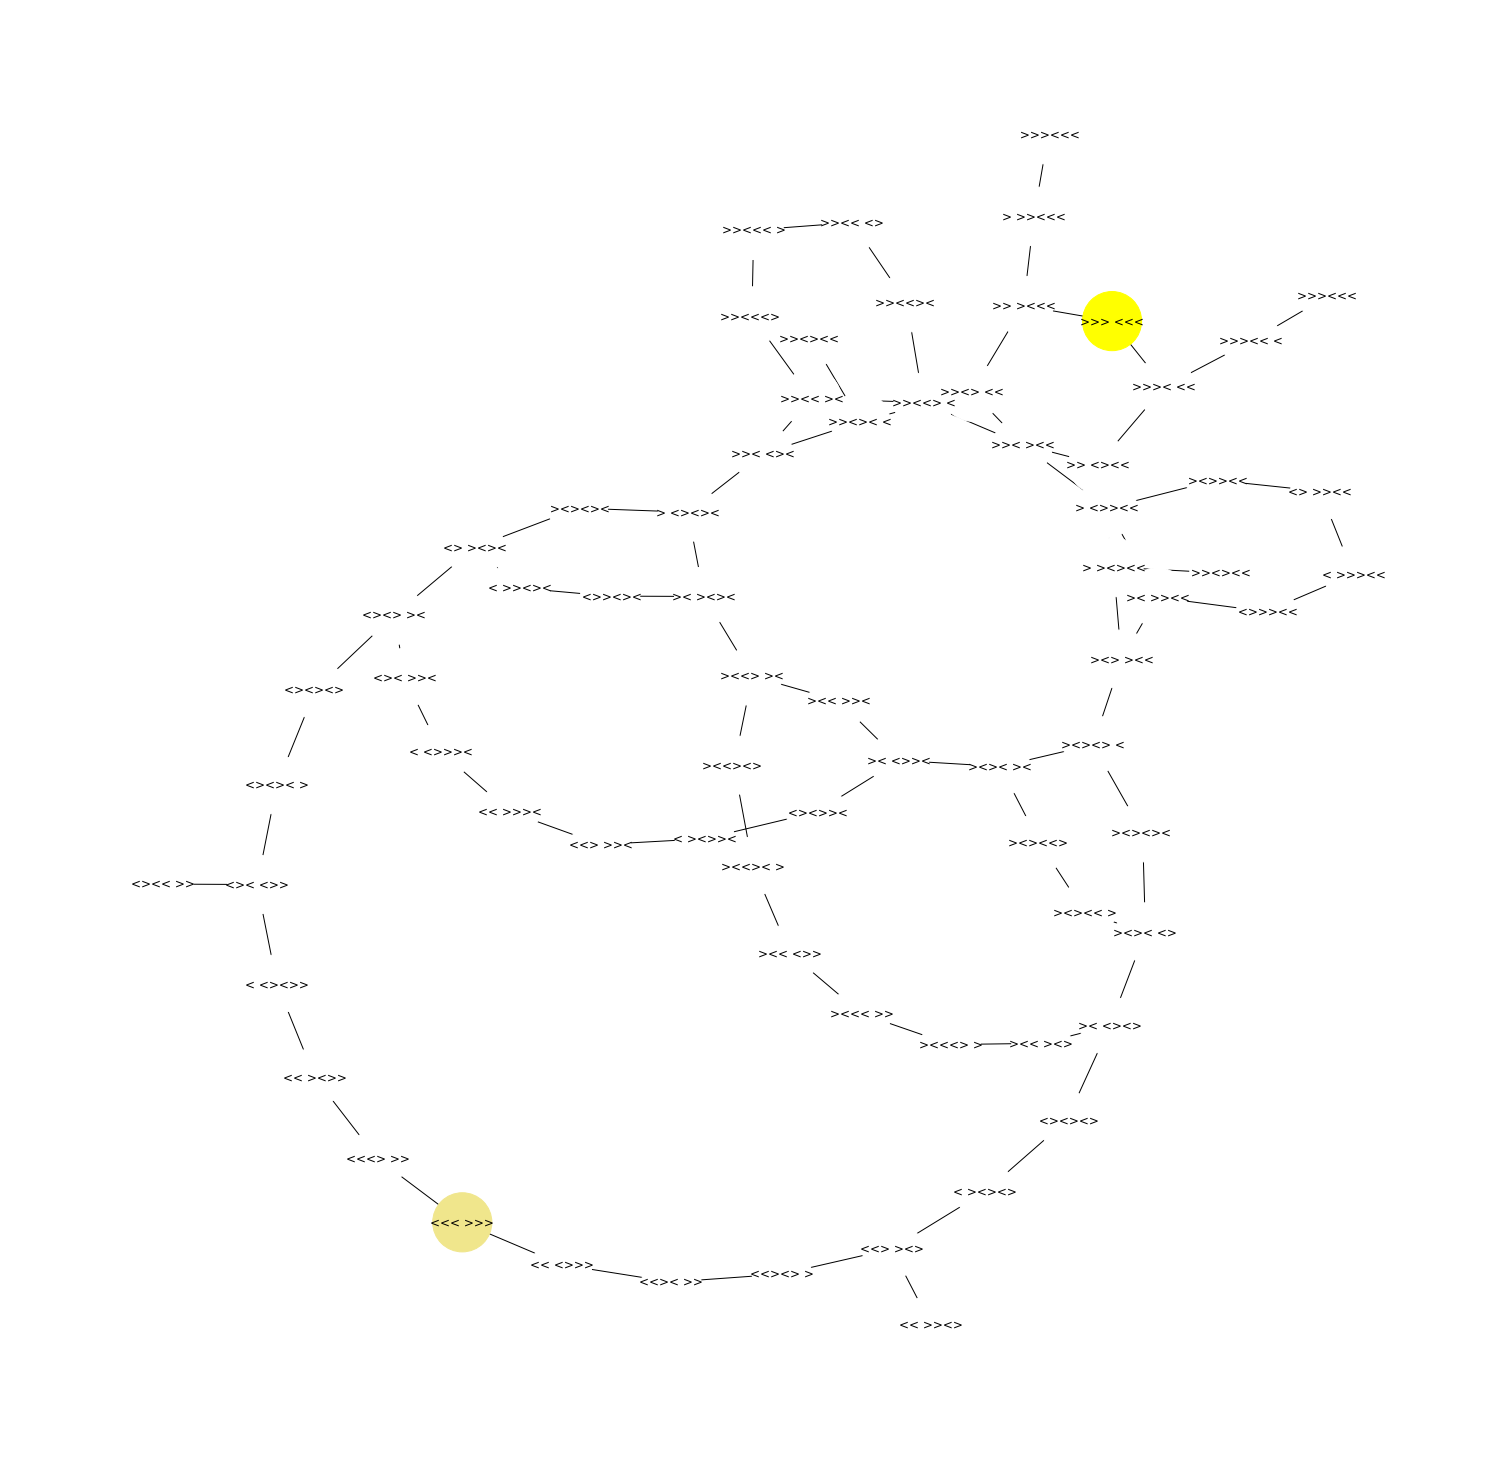

In [58]:
plt.figure(figsize=[20, 20])
g = nx.Graph()
g.add_weighted_edges_from([
    (source, dest, weight)
    for source, edges in graph(DocksHoistPuzzle).items()
    for dest, weight in edges.items()
])
g.add_node('>>> <<<')

nodes = list(g.nodes)
colors = ['white'] * len(nodes)
colors[nodes.index('>>> <<<')] = 'yellow'
colors[nodes.index('<<< >>>')] = 'khaki'

nx.draw_kamada_kawai(
    g, 
    with_labels=True, 
    node_size=3500, 
    node_color=colors
)

### Vacuum World

#### State

![Vacuum World State](./images/va1.png)

#### State Space

![Vacuum World State Space](./images/VacuumWorld.JPG)

#### Formulation

In [4]:
class VacuumWorld:
    @staticmethod
    def initial_state():
        #       location, left-dirty, right dirty
        return ('L'     , True      , True       )

    @staticmethod
    def actions(state):
        loc, ld, rd = state
        result = ['S']
        if loc == 'L':
            result.append('R')
        if loc == 'R':
            result.append('L')
        return result
        
    @staticmethod
    def result(state, action):
        loc, ld, rd = state
        if action == 'S':
            if loc == 'L':
                ld = False
            if loc == 'R':
                rd = False
        else:
            loc = action
        return (loc, ld, rd)

    @staticmethod
    def step_cost(start, action, end):
        return 1

    @staticmethod
    def goal_test(state):
        return state[1:] == (False, False)

In [5]:
space(VacuumWorld)

[('L', True, True),
 ('L', False, True),
 ('R', True, True),
 ('R', False, True),
 ('R', True, False),
 ('R', False, False),
 ('L', True, False),
 ('L', False, False)]

### Sliding Puzzle

#### Problem

![](./images/sliding_puzzle.png)

#### Formulation

In [6]:
class SlidingPuzzle:
    @staticmethod
    def initial_state():
        return (
            (7, 2, 4),
            (5, 0, 6),
            (8, 3, 1)
        )

    @staticmethod
    def actions(state):
        r, c = [(row, cols.index(0)) for row, cols in enumerate(state) if 0 in cols][0]
        results = [
            ((r, c), (r+1, c)),
            ((r, c), (r, c+1)),
            ((r, c), (r-1, c)),
            ((r, c), (r, c-1)),
        ]
        return [
            ((r0, c0), (r1, c1) )
            for (r0, c0), (r1, c1) 
            in results 
            if (r1 in {0, 1, 2}) and (c1 in {0, 1, 2})
        ]
        
    @staticmethod
    def result(state, action):
        state = list(map(list, state))
        (r0, c0), (r1, c1) = action
        state[r0][c0], state[r1][c1] = state[r1][c1], state[r0][c0]
        return tuple(map(tuple, state))

    @staticmethod
    def step_cost(start, action, end):
        return 1

    @staticmethod
    def goal_test(state):
        return state[1:] == (False, False)

In [7]:
len(space(SlidingPuzzle))

181440

### 8-Queens

#### Problem

![](./images/8-queens-unique_solutions.png)

In [8]:
class EightQueens:
    @staticmethod
    def initial_state():
        return ()

    @staticmethod
    def actions(state):
        if len(state) == 8:
            return []
        
        results = set(range(8))
        results -= set(state)
        
        altr_diag = {row + col for col, row in enumerate(state)}
        main_diag = {8 - row + col for col, row in enumerate(state)}
        
        for r in list(results):
            if (r + len(state)) in altr_diag:
                results.remove(r)
            elif (8 - r + len(state)) in main_diag:
                results.remove(r)
        
        return results
        
        
    @staticmethod
    def result(state, action):
        return state + (action,)

    @staticmethod
    def step_cost(start, action, end):
        return 1

    @staticmethod
    def goal_test(state):
        return len(state) == 8

In [9]:
q = space(EightQueens)

In [10]:
def threneted_list(queens):
    size = len(queens)
    thretenings = len(queens) * [0]

    c = Counter(row + col for row, col in zip(range(size - 1, -1, -1), queens))
    for idx, (row, col) in enumerate(zip(range(size - 1, -1, -1), queens)):
        thretenings[idx] += c[row + col] - 1

    c = Counter(row + col for row, col in zip(range(0, size, 1), queens))
    for idx, (row, col) in enumerate(zip(range(0, size, 1), queens)):
        thretenings[idx] += c[row + col] - 1

    return thretenings

def to_chessboard(queens):
    size = len(queens)
    
    threats = np.zeros([size, size], dtype=np.int)
    
    board = np.ones([size, size])
    board[::2, ::2] = 1/20
    board[1::2, 1::2] = 1/20
    
    board[np.ogrid[:len(queens)], queens] = 0.5
    
    for row, (col, t) in enumerate(zip(queens, threneted_list(queens))):
        if t == 0:
            board[row, col] = 2 / 10
        else:
            board[row, col] = 3 / 10
            threats[row, col] = t
    
    return board, threats

def plot_chessboard(queens, text_size=15, animated=False):
    size = len(queens)
    
    ax = plt.gca()
    ax.set_xlim([-0.5, size - 0.5])
    ax.set_ylim([-0.5, size - 0.5])
    ax.set_xticks([])
    ax.set_yticks([])

    board, threats = to_chessboard(queens)
    image = plt.imshow(
        board, 
        interpolation='nearest', 
        cmap=plt.cm.tab20, 
        norm=matplotlib.colors.NoNorm(),
        animated=animated
    )
    
    if text_size:
        texts = []
        for i, row in enumerate(threats):
            row_texts = []
            for j, cell in enumerate(row):
                text = '' if cell == 0 else str(cell)
                row_texts.append(
                    ax.text(j, i, text, color='white', fontsize=text_size, animated=animated)
                )
            texts.append(row_texts)
        return image, texts
    else:
        return image

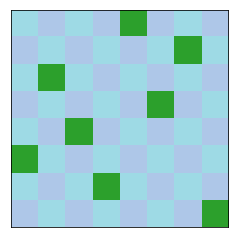

In [11]:
plot_chessboard(q[-1]);

### Knuth's $\sqrt{x}$, $\lfloor x \rfloor$, $x!$

#### Problem

Every number can be obtained by applying:

* $\sqrt{x}$
* $\lfloor x \rfloor$
* $x!$

Repeatedly. starting by number 4.

For example:

$$ \lfloor \sqrt{\sqrt{\sqrt{\sqrt{\sqrt{(4!)!}}}}} \rfloor = 5 $$

#### Formulation

In [12]:
class KnuthProblem:
    @staticmethod
    def initial_state():
        return 4

    @staticmethod
    def actions(state):
        result = ['sqrt', 'floor']
        if isinstance(state, int) and state <= 100:
            result.append('factorial')
        return result
        
    @staticmethod
    def result(state, action):
        import math
        if action == 'floor':
            return int(state)
        if action == 'sqrt':
            return math.sqrt(state)
        if action == 'factorial':
            n = 1
            for i in range(1, state + 1):
                n *= i
            return n
        raise Exception(f'Invalid action {action}')

    @staticmethod
    def step_cost(start, action, end):
        return 1

    @staticmethod
    def goal_test(state):
        return 5

In [13]:
sum(1 for x in itertools.islice(generate_space(KnuthProblem), 1000))

1000

#### The Challenge

Each path is infinite!

In [14]:
def factorial(k):
    n = 1
    for i in range(1, k+1):
        n *= i
    return n

In [15]:
def sqrtn(n, k):
    import math
    for i in range(k):
        n = math.sqrt(n)
    return n

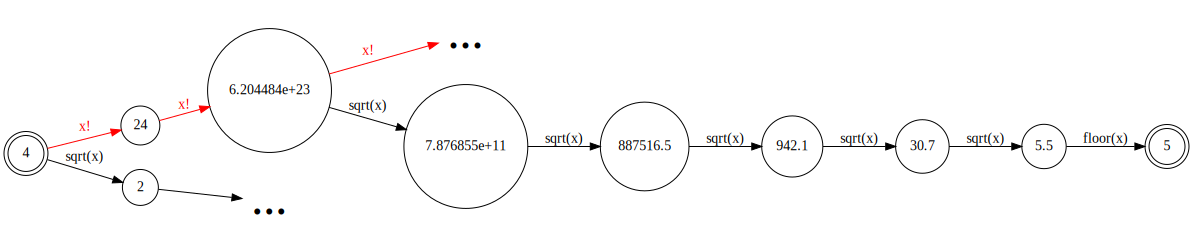

In [16]:
kg = Digraph(comment='DFS is Incomplete')
kg.attr(rankdir='LR')

f4 = str(factorial(4))
ff4 = f'{factorial(factorial(4)):e}'
sff4 = f'{sqrtn(factorial(factorial(4)), 1):e}'
ssff4 = f'{sqrtn(factorial(factorial(4)), 2):.1f}'
sssff4 = f'{sqrtn(factorial(factorial(4)), 3):.1f}'
ssssff4 = f'{sqrtn(factorial(factorial(4)), 4):.1f}'
sssssff4 = f'{sqrtn(factorial(factorial(4)), 5):.1f}'

kg.node('4', shape='doublecircle')
kg.node(f4, shape='circle')
kg.node(ff4, shape='circle')
kg.node('L1', '...', shape='plaintext', fontsize='50')
kg.node(sff4, shape='circle')
kg.node(ssff4, shape='circle')
kg.node(sssff4, shape='circle')
kg.node(ssssff4, shape='circle')
kg.node(sssssff4, shape='circle')
kg.node('5', shape='doublecircle')

kg.edge('4', f4, label='x!', color='red', fontcolor='red')
kg.edge(f4, ff4, label='x!', color='red', fontcolor='red')
kg.edge(ff4, 'L1', label='x!', color='red', fontcolor='red')
kg.edge(ff4, sff4, label='sqrt(x)')
kg.edge(sff4, ssff4, label='sqrt(x)')
kg.edge(ssff4, sssff4, label='sqrt(x)')
kg.edge(sssff4, ssssff4, label='sqrt(x)')
kg.edge(ssssff4, sssssff4, label='sqrt(x)')
kg.edge(sssssff4, '5', label='floor(x)')

kg.node('2', shape='circle')
kg.node('L2', '...', shape='plaintext', fontsize='50')
kg.edge('2', 'L2')
kg.edge('4', '2', label='sqrt(x)')

kg

## Searching for Solutions

### Node, Queue, Stack

In [17]:
Node = namedtuple('Node', 'state parent action path_cost')

def child_node(problem, parent, action):
    state = problem.result(parent.state, action)
    return Node(
        state=state,
        parent=parent,
        action=action,
        path_cost=parent.path_cost + problem.step_cost(parent.state, action, state)
    )

def initial_node(problem):
    return Node(problem.initial_state(), None, None, 0)

In [18]:
class Stack:
    def __init__(self):
        self._data = []
        
    def __bool__(self):
        return bool(self._data)
    
    def pop(self):
        return self._data.pop()
    
    def insert(self, element):
        return self._data.append(element)
    
    def __repr__(self):
        return f'Stack({self._data!r})'

In [19]:
class Queue:
    def __init__(self):
        self._data = deque()
    
    def __bool__(self):
        return bool(self._data)
    
    def pop(self):
        return self._data.popleft()
    
    def insert(self, element):
        return self._data.append(element)
    
    def __repr__(self):
        return f'Queue({self._data!r})'

### Measuring problem solving performance

#### Completeness

Is the algorithm guranteed to find a solution when there is one?

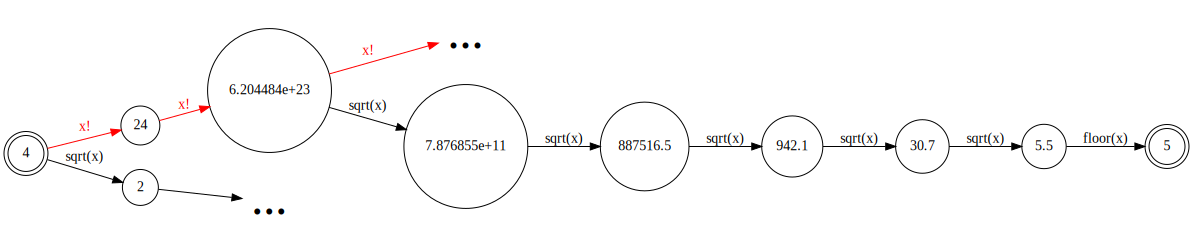

In [20]:
kg

#### Optimality

Does the strategy find the optimal solution?

#### Time complexity

How long does it take to find a solution?

#### Space complexity

How much memory is needed to perform the search?

#### etc

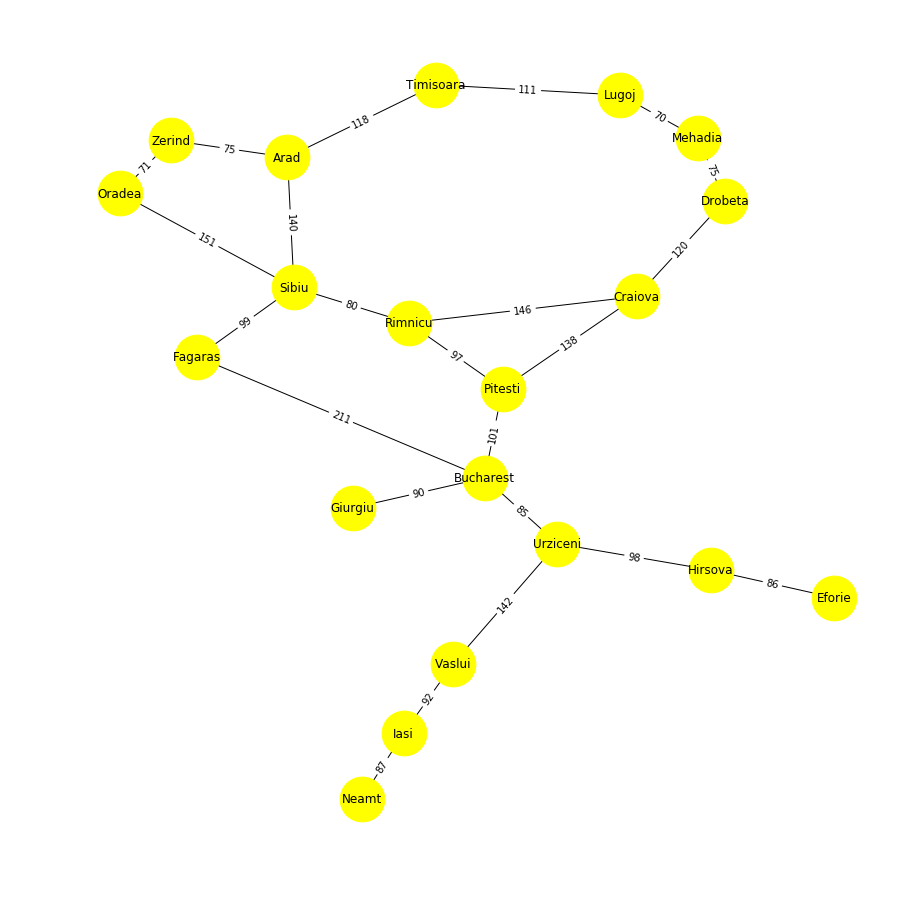

In [97]:
romania_map = dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142))

plt.figure(figsize=[12, 12])

g = nx.Graph()

nodes = set(romania_map.keys())
nodes |= set(y for x in romania_map.values() for y in x.keys())
nodes = list(nodes)
edges = [(s, d, w) for s, e in romania_map.items() for d, w in e.items()]

g.add_nodes_from(nodes)
g.add_weighted_edges_from(edges)

pos = nx.layout.kamada_kawai_layout(g)

nx.draw(
    g, 
    pos,
    with_labels=True,
    node_size=2000, 
    node_color='yellow'
)
nx.draw_networkx_edge_labels(
    g,
    pos,
    edge_labels={
        (s, d): w
        for s, d, w
        in edges
    }
);